In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda-2.4.0/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['savefig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import sys
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/')


In [6]:
import pandas as pd
import os
from scipy import stats
from utils import loadmat
import matplotlib.gridspec as gridspec
from utils import fdr_correct

In [3]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
savedir = '/home/knight/matar/NHB_submission_2017'
savefig = True

## load data
### traces grouped by RT in bins of 50ms
* without my data
* dropped SR

In [8]:
#load data (without my data, without SR)
p = 'D'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata, allRTs, allsubjs, alltasks, alloffsets = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs)
allRTs = allRTs[i]
alldata = alldata[i,:]
allsubjs = allsubjs[i]
alltasks = alltasks[i]
alloffsets = alloffsets[i]

p = 'R'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata_resp, allRTs_resp, allsubjs_resp, alltasks_resp, alloffsets_resp = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs_resp)
allRTs_resp = allRTs_resp[i]
alldata_resp = alldata_resp[i,:]
allsubjs_resp = allsubjs_resp[i]
alltasks_resp = alltasks_resp[i]
alloffsets_resp = alloffsets_resp[i]

## Custom Bins

In [9]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL','Bin_Stats_v1_D+R.csv')
df_val = pd.read_csv(filename)

/sw/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/sw/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:66: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(536, 534)
(713, 747)
(620, 768)
(346, 298)
(275, 188)
(164, 82)
/home/knight/matar/NHB_submission_2017


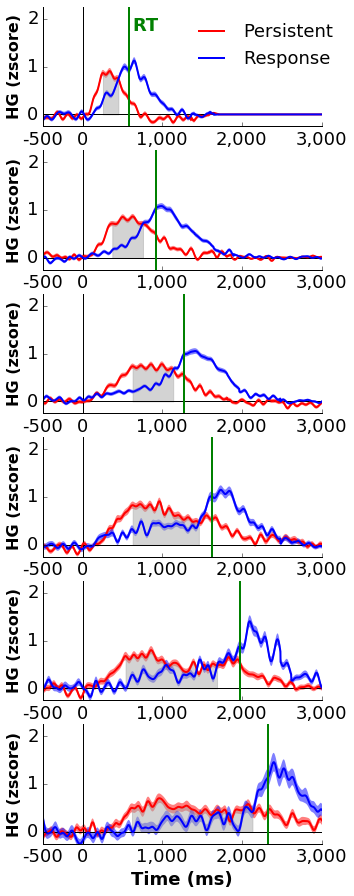

In [11]:
lats, lats_resp, rts, rts_resp, offsets, task_proportion, task_proportion_resp, lats_fromoffset = [[] for i in range(8)]
prop_dict, count_dict = [dict() for i in range(2)]

bins = np.arange(allRTs.min(), allRTs.max(), 50)

f, ax = plt.subplots(6, 1, figsize = (5,15))

binlist =[576, 925, 1277, 1626, 1975, 2328]

cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    if len(np.arange(start_i_resp, end_i_resp+1))<50:
        continue
                
    
    data = alldata[start_i:end_i+1,:]
    data_resp = alldata_resp[start_i_resp:end_i_resp+1,:]
    offset = alloffsets[start_i:end_i+1].mean()
    
    #extract latency
    lats.append(np.argmax(data.mean(axis =0))-500)
    lats_resp.append(np.argmax(data_resp.mean(axis = 0))-500)
    rts.append(allRTs[start_i:end_i+1].mean())
    rts_resp.append(allRTs_resp[start_i_resp:end_i_resp+1].mean())
    offsets.append(offset)
    lats_fromoffset.append(np.argmax(data.mean(axis = 0)[offset:])-500)
    
    idx = np.argmin(abs(rts - np.floor(rts[-1])))
    t2 = df_val.iloc[idx]['t2 (last cross)']
    t4 = df_val.iloc[idx]['1st dur peak (t4)']

    if df_val.iloc[idx]['RT'] not in (binlist):
        continue

    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)
    

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'Persistent')# (%i trials)') %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, label = 'Response')# (%i trials)') %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2)#, label = 'RT: %i ms' %(allRTs[start_i:end_i+1].mean()))
    
    ax[cnt].fill_between(np.arange(t4, t2), 0,  data.mean(axis = 0)[t4+500:t2+500], color = 'darkgray', alpha = 0.5)

 
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 16, fontweight = 'bold')
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 3000])
    ax[cnt].set_xticks([-500, 0, 1000, 2000, 3000])
    ax[cnt].set_yticks(np.arange(0, 3, 1))

    ax[cnt].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax[cnt].xaxis.set_tick_params(labelsize = 18)
    ax[cnt].yaxis.set_tick_params(labelsize = 18)
    #ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'off', right = 'off', left = 'off')
                    
    handles, labels = ax[0].get_legend_handles_labels()
    lgnd = ax[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,1), frameon = False, fontsize = 18)
 
    print (len(allRTs[start_i:end_i+1]),(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    
    cnt += 1
    
ax[cnt-1].set_xlabel('Time (ms)', fontsize = 18, fontweight = 'bold')
            
    
 
ax[0].annotate('RT', xy = (binlist[0]+50, 1.75), color = 'g', fontsize = 18, weight = 'bold')
#ax[1].annotate('sustained', xy = (40, 1.1), color = 'r', fontsize = 14, weight = 'bold')
#ax[1].annotate('response', xy = (750, 1.1), color = 'b', fontsize = 14, weight = 'bold')
                 
filename = os.path.join(savedir, 'Fig2_binsBycluster_persistent.png')

f.savefig(filename,bbox_inches='tight', dpi = 150)

print savedir